In [66]:
import gseapy as gp
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.stats
from collections import defaultdict

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

import re
from gseapy import Biomart

import matplotlib.pyplot as plt
import seaborn as sns
from scripts import aesthetics

aesthetics.activate_paper_rcParams()

# Analyze Gene Set Enrichment Results

My previous notebook, where I generated the results for the gene set enrichment results (`cwas-gene-set-enrichment`), was getting way too long. I'll use this notebook to analyze the results instead.

# Load in our data

We have to load in all our appropriate data, including SVs and the gene set enrichment results.

## Read in SVs

In [14]:
# define SVs and dosages for discovery and validation
sv_path = "gs://vanallen-pedsv-analysis/beds/archive/v2.5.2/PedSV.v2.5.2.full_cohort.analysis_samples.sites.bed.gz"
dosages_path = "gs://vanallen-pedsv-analysis/beds/archive/v2.5.2/PedSV.v2.5.2.full_cohort.analysis_samples.allele_dosages.bed.gz"

# define metadata
metadata_path = "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.2.cohort_metadata.w_control_assignments.tsv.gz"
samples_path = "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.2.final_analysis_cohort.samples.list"

# list of genes that are annotated - drop ensembl IDs
gene_ref = pd.read_csv("ref/gencode_hg38_protein_coding_genes_for_annotation_7_31_23.txt")
gene_ref = gene_ref[~gene_ref['value'].str.startswith('ENSG00')]
gene_ref = gene_ref['value'].tolist()

Load metadata and SVs

In [15]:
metadata = pd.read_csv(
    metadata_path,
    sep="\t",
)

# add a sex label to metadata
metadata["sex"] = (metadata["chrX_CopyNumber"].round() < 2).astype(int)

###############
### Samples ###
###############
nbl_cases = metadata[
    (metadata["neuroblastoma_case"] == True)
]["entity:sample_id"].tolist()

nbl_controls = metadata[
    (metadata["neuroblastoma_control"] == True)
]["entity:sample_id"].tolist()

Now we load the SVs. We'll eventually combine discovery and validation data, but it's easiest to keep them separate for now, since the SVs and dosages are not fully overlapping.

In [16]:
###############
##### SVs #####
###############
svs = pd.read_csv(
    sv_path,
    sep="\t",
)

###############
### Dosages ###
###############
dosages = pd.read_csv(
    dosages_path,
    sep="\t",
    index_col=False,
)

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (10,34,35,37,39,41,45,46,47,48,72,73,87,88,106,107,121,122,136,137,155,156,170,171,185,186,204,205,219,220,234,235,253,254,268,269,283,284,302,303,366,367,381,382,400,401,415,416,430,431,449,450,464,465,479,480,498,499,513,514,528,529,547,548,562,563,577,578,596,597,645,646,647,648,649,650,690,691,692,693,694,695,713,714,728,729,743,744,758,759,773,774,788,789,803,804,818,819,833,834,848,849,863,864,878,879,893,894,908,909,923,924,931,937,943) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Read in the category results

I'm going to concatenate all this data so that I'm only dealing with a few files. Focusing on neuroblastoma.

In [17]:
###########
### SVs ###
###########
nbl_coding_svs = pd.read_csv(
    "data/CWAS data for Jett/List of variants by category for each CWAS analysis/neuroblastoma_all_coding_SVs_in_each_category_list_combined_11_3_23.txt",
    sep="\t",
)

nbl_noncoding_svs = pd.read_csv('data/CWAS data for Jett/List of variants by category for each CWAS analysis/neuroblastoma_all_noncoding_SVs_in_each_category_list_combined_BURDEN_TESTING_with_col_names_11_3_23.txt', sep='\t')
nbl_noncoding_svs = nbl_noncoding_svs.rename(columns = {'emd': 'end'})

# combine the SVs
nbl_coding_svs['sv_category'] = 'coding'
nbl_noncoding_svs['sv_category'] = 'non-coding'

nbl_category_svs = pd.concat([nbl_coding_svs, nbl_noncoding_svs])
nbl_category_svs.head(2)

,SV,chrom,start,end,category,sv_category
0,PedSV.2.5.2_DUP_chr1_794,chr1,19221626,19301822,DUP.RARE.PREDICTED_COPY_GAIN.lof_constrained.e...,coding
1,PedSV.2.5.2_DUP_chr1_1379,chr1,44731601,44792024,DUP.RARE.PREDICTED_COPY_GAIN.lof_constrained.e...,coding


In [18]:
#########################
### FRAMEWORK RESULTS ###
#########################
nbl_singleton_coding_framework_results = pd.read_csv(
    "data/CWAS data for Jett/CWAS sum stats/neuroblastoma_all_coding_cwas_concatenated_glm_results_SINGLETON_11_3_23.txt",
    sep="\t",
)
nbl_singleton_coding_framework_results[['af_category', 'sv_category']] = ['singleton', 'coding']

nbl_rare_coding_framework_results = pd.read_csv(
    "data/CWAS data for Jett/CWAS sum stats/neuroblastoma_all_coding_cwas_concatenated_glm_results_RARE_11_3_23.txt",
    sep="\t",
)
nbl_rare_coding_framework_results[['af_category', 'sv_category']] = ['rare', 'coding']

nbl_singleton_noncoding_framework_results = pd.read_csv(
    "data/CWAS data for Jett/CWAS sum stats/neuroblastoma_all_noncoding_cwas_concatenated_glm_results_SINGLETON_11_3_23.txt",
    sep="\t",
)
nbl_singleton_noncoding_framework_results[['af_category', 'sv_category']] = ['singleton', 'non-coding']

nbl_rare_noncoding_framework_results = pd.read_csv(
    "data/CWAS data for Jett/CWAS sum stats/neuroblastoma_all_noncoding_cwas_concatenated_glm_results_RARE_11_3_23.txt",
    sep="\t",
)
nbl_rare_noncoding_framework_results[['af_category', 'sv_category']] = ['rare', 'non-coding']

nbl_framework_results = pd.concat([nbl_singleton_coding_framework_results, nbl_rare_coding_framework_results, 
                                   nbl_singleton_noncoding_framework_results, nbl_rare_noncoding_framework_results])

In [19]:
nbl_framework_results.head(2)

,point_estimate,std_error,z_score,p_value,SV_counts_cases,SV_counts_cases_max,number_of_cases_with_zero_SVs,total_cases,SV_counts_controls,SV_counts_controls_max,number_of_controls_with_zero_SVs,total_controls,number_of_unique_SVs,category_name,sv_type,frequency,mean_SVs_per_case,mean_SVs_per_control,mean_SVs_total,negative_log10_p_value,af_category,sv_category
0,0.271918,0.051227,5.308100,1.110000e-07,438,5,336,646,2441,4,2848,4700,459,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,ANY,SINGLETON,0.678019,0.519362,0.538533,6.955563,singleton,coding
1,0.276065,0.054006,5.111756,3.190000e-07,393,5,356,646,2172,4,3012,4700,411,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,DEL,SINGLETON,0.608359,0.462128,0.479798,6.495968,singleton,coding


In [20]:
nbl_coding_framework = pd.read_csv(
    "data/CWAS data for Jett/CWAS frameworks/CWAS_categories_neuroblastoma_coding_8_17_23.txt",
    sep="\t",
)

nbl_noncoding_framework = pd.read_csv(
    "data/CWAS data for Jett/CWAS frameworks/CWAS_rare_categories_neuroblastoma_noncoding_10_2_23.txt",
    sep="\t",
)

In [215]:
nbl_coding_framework

,sv_type,frequency,genic_relationship,constraint,expression,gene_group
0,DUP,RARE,PREDICTED_COPY_GAIN,lof_constrained,expressed_in_adrenal_gland,protein_coding
1,DEL,SINGLETON,PREDICTED_INTRAGENIC_EXON_DUP,missense_constrained,ANY,cosmic_cancer_genes
2,CPX_or_INV,NaN,PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP,unconstrained,NaN,germline_CPGs
3,INS_ALL,NaN,ANY,ANY,NaN,base_excision_repair_genes
4,ANY,NaN,NaN,NaN,NaN,chromatin_organization_genes
5,NaN,NaN,NaN,NaN,NaN,dna_damage_bypass_genes
6,NaN,NaN,NaN,NaN,NaN,dna_damage_reversal_genes
7,NaN,NaN,NaN,NaN,NaN,dna_DSB_repair_genes
8,NaN,NaN,NaN,NaN,NaN,dna_DSB_response_genes
9,NaN,NaN,NaN,NaN,NaN,dna_repair_genes


In [214]:
nbl_noncoding_framework

,sv_type,frequency,functional_intersection,functional_category,genic_relationship,constraint,expression,gene_group
0,DUP,RARE,PREDICTED_NONCODING_BREAKPOINT,neuroblastoma_atac_peaks,PREDICTED_INTERGENIC,lof_constrained,expressed_in_adrenal_gland,protein_coding
1,DEL,SINGLETON,PREDICTED_NONCODING_SPAN,neuroblastoma_chromHMM15_Enh,PREDICTED_INTRONIC,ANY,ANY,cosmic_and_germline_CPGs
2,CPX_or_INV,NaN,ANY,neuroblastoma_chromHMM15_Enh_conserved,PREDICTED_PROMOTER,NaN,NaN,NaN
3,INS_ALL,NaN,NaN,neuroblastoma_chromHMM15_EnhG,PREDICTED_UTR,NaN,NaN,NaN
4,ANY,NaN,NaN,neuroblastoma_chromHMM15_EnhG_conserved,ANY,NaN,NaN,NaN
5,NaN,NaN,NaN,neuroblastoma_H3K27Ac_peak,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,neuroblastoma_chromHMM15_TssAFlnk,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,neuroblastoma_ABC_MAX_enhancer,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,neuroblastoma_atac_peaks_conserved,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,neuroblastoma_chromHMM15_EnhBiv,NaN,NaN,NaN,NaN


Read in our GSE results

In [80]:
result_gene_lists = pd.read_csv('data/cwas-results/gene-set-enrichment-analysis-counts.csv')
gse_results = pd.read_csv('data/cwas-results/cwas-gene-set-enrichment-results.csv')

Now we read in the gene sets

In [47]:
gene_sets = defaultdict(dict)
with open('ref/gene-sets.txt') as infile:
    for line in infile.readlines():
        line = line.strip().split(',')
        db = line[0]
        gs = line[1]
        gene_sets[db][gs] = line[2:]

# Add FDRs

In [77]:
# for cat in set(gse_results['category']):
#     for db in gene_sets.keys():
#         for sv_incl_strat in ['multiple', 'single']:
#             subdata = gse_results[(gse_results['category'] == cat) &
#                                   (gse_results['db'] == db) &
#                                   (gse_results['sv_incl_strat'] == sv_incl_strat)]
            
#             fdr_p = statsmodels.stats.multitest.multipletests(subdata['p_cases_unique'].to_list(), method='fdr_bh')[1]
            
#             gse_results.loc[subdata.index, 'q_cases_unique'] = fdr_p

In [79]:
# gse_results.to_csv('data/cwas-results/cwas-gene-set-enrichment-results.csv', index=False)

In [90]:
# gse_results.query('sv_category == "non-coding" & q_cases_unique < 0.05 & sv_incl_strat == "single" & num_unique_gene_overlaps_cases_unique > 1').groupby(['db'])['gs'].value_counts()

# Analyze high level results

We underwent numerous filtering steps to try to distill things down to reliable results. We have a high index of suspicion for ANY significant result, but let's at least see:

Let's start by examining the most "stringent" criteria. `single` for `sv_incl_strat`, significant in unique cases, non-significant in controls, and at least two genes overlapping with the gene set.

In [169]:
coding_stringent_results = gse_results[(gse_results['sv_category'] == 'coding') &
                                       (gse_results['sv_incl_strat'] == 'single') &
                                       (gse_results['p_controls'] > 0.05) &
                                       (gse_results['num_unique_gene_overlaps_cases_unique'] > 1)].copy()

coding_stringent_results['-logq'] = -np.log10(coding_stringent_results['q_cases_unique'])
coding_stringent_results['log-odds'] = np.log(coding_stringent_results['res_cases_unique'])

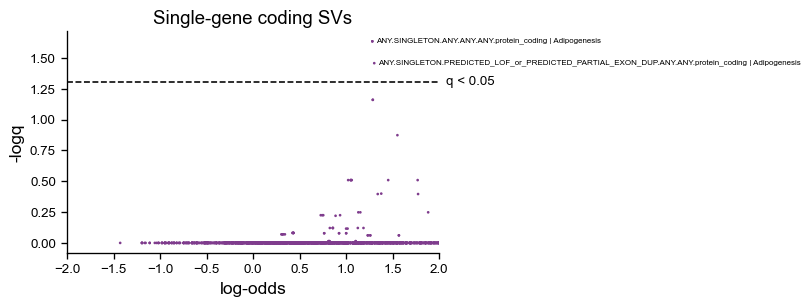

In [170]:
fig, ax = plt.subplots(1, figsize = (5, 3))
sns.scatterplot(x = 'log-odds', y = '-logq', data = coding_stringent_results,
                ec = None, s = 4)
ax.set_xlim([-2, 2])
ax.set_title('Single-gene coding SVs')
sns.despine(ax = ax)
ax.axhline(y = -np.log10(0.05), linestyle = 'dashed', color = 'black')
ax.text(x = 1.02, y = 0.76, s = 'q < 0.05', transform = ax.transAxes, fontsize = 10)

for index, row in coding_stringent_results.query('q_cases_unique < 0.05').iterrows():
    if 'UMBRELLA' in row['category']: 
        continue
    
    x = row['log-odds']
    y = row['-logq']
    s = row['category'] + ' | ' + row['gs']
    ax.text(x = x + 0.04, y = y, s = s, fontsize = 6, ha = 'left', va = 'center')
    
fig.savefig('data/cwas-results/single-gene-coding-svs-gene-set-enrichment-plot.png', bbox_inches = 'tight')

So there's a lot of fatty acid metabolism here. I have no real clue what this means, but there is precedence for fatty acid metabolism being relevant in NBL: https://pubmed.ncbi.nlm.nih.gov/35531888/

In [168]:
noncoding_stringent_results = gse_results[(gse_results['sv_category'] == 'non-coding') &
                                          (gse_results['sv_incl_strat'] == 'single') &
                                          (gse_results['p_controls'] > 0.05) &
                                          (gse_results['num_unique_gene_overlaps_cases_unique'] > 1)].copy()

noncoding_stringent_results['-logq'] = -np.log10(noncoding_stringent_results['q_cases_unique'])
noncoding_stringent_results['log-odds'] = np.log(noncoding_stringent_results['res_cases_unique'])

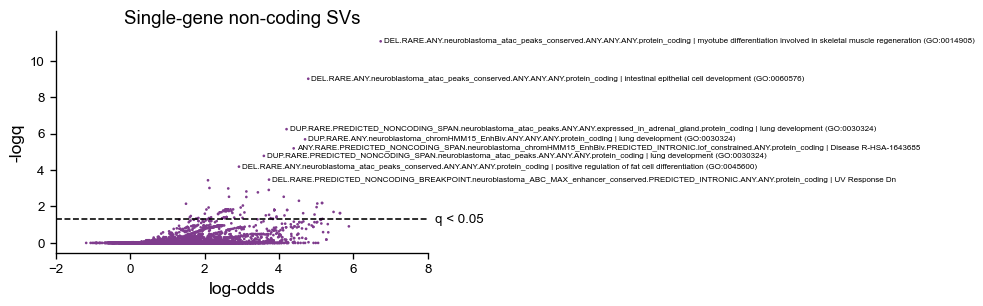

In [189]:
fig, ax = plt.subplots(1, figsize = (5, 3))
sns.scatterplot(x = 'log-odds', y = '-logq', data = noncoding_stringent_results,
                ec = None, s = 4)
ax.set_xlim([-2, 8])
ax.set_title('Single-gene non-coding SVs')
sns.despine(ax = ax)
ax.axhline(y = -np.log10(0.05), linestyle = 'dashed', color = 'black')
ax.text(x = 8.2, y = -np.log10(0.05), s = 'q < 0.05', fontsize = 10, va = 'center')

for i, (index, row) in enumerate(noncoding_stringent_results.query('q_cases_unique < 0.05').sort_values(by = '-logq', ascending = False).iterrows()):
    
    if i > 7:
        continue
    
    x = row['log-odds']
    y = row['-logq']
    s = row['category'] + ' | ' + row['gs']
    ax.text(x = x + 0.08, y = y, s = s, fontsize = 6, ha = 'left', va = 'center')
    
fig.savefig('data/cwas-results/single-gene-non-coding-svs-gene-set-enrichment-plot.png', bbox_inches = 'tight')

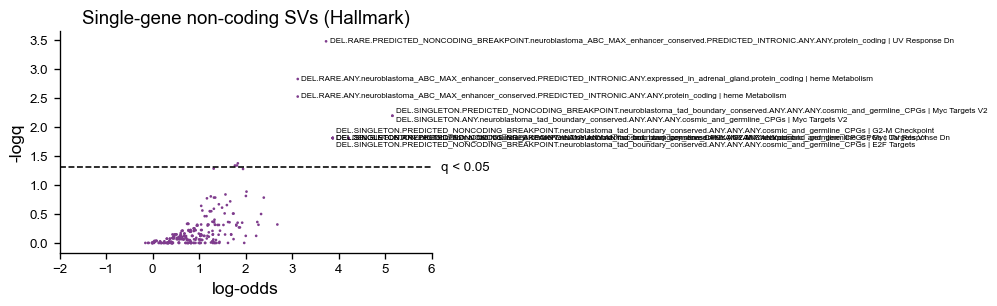

In [207]:
fig, ax = plt.subplots(1, figsize = (5, 3))
sns.scatterplot(x = 'log-odds', y = '-logq', data = noncoding_stringent_results.query('db == "MSigDB_Hallmark_2020"'),
                ec = None, s = 4)
ax.set_xlim([-2, 6])
ax.set_title('Single-gene non-coding SVs (Hallmark)')
sns.despine(ax = ax)
ax.axhline(y = -np.log10(0.05), linestyle = 'dashed', color = 'black')
ax.text(x = 6.2, y = -np.log10(0.05), s = 'q < 0.05', fontsize = 10, va = 'center')

for i, (index, row) in enumerate(noncoding_stringent_results.query('q_cases_unique < 0.05 & db == "MSigDB_Hallmark_2020"').sort_values(by = '-logq', ascending = False).iterrows()):
    
    if i > 9:
        continue
    
    x = row['log-odds']
    y = row['-logq']
    
    if i == 3:
        y += 0.08
    if i == 4:
        y += -0.08
        
    if i == 5:
        y += 0.12
    if i == 6:
        y += -0.12
        
    s = row['category'] + ' | ' + row['gs']
    ax.text(x = x + 0.08, y = y, s = s, fontsize = 6, ha = 'left', va = 'center')
    
fig.savefig('data/cwas-results/single-gene-non-coding-svs-gene-set-enrichment-plot-hallmark.png', bbox_inches = 'tight')

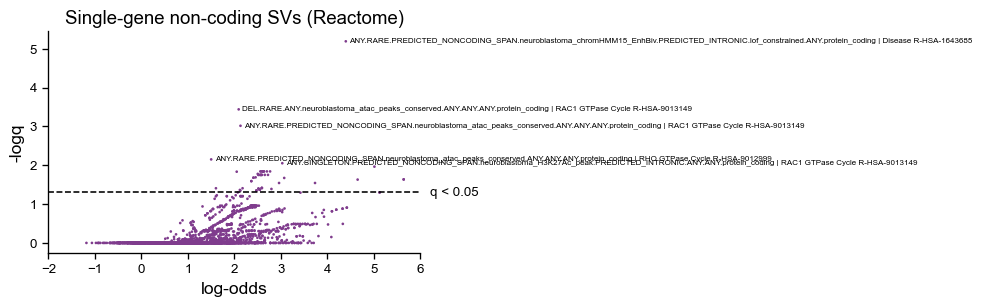

In [212]:
fig, ax = plt.subplots(1, figsize = (5, 3))
sns.scatterplot(x = 'log-odds', y = '-logq', data = noncoding_stringent_results.query('db == "Reactome_2022"'),
                ec = None, s = 4)
ax.set_xlim([-2, 6])
ax.set_title('Single-gene non-coding SVs (Reactome)')
sns.despine(ax = ax)
ax.axhline(y = -np.log10(0.05), linestyle = 'dashed', color = 'black')
ax.text(x = 6.2, y = -np.log10(0.05), s = 'q < 0.05', fontsize = 10, va = 'center')

for i, (index, row) in enumerate(noncoding_stringent_results.query('q_cases_unique < 0.05 & db == "Reactome_2022"').sort_values(by = '-logq', ascending = False).iterrows()):
    
    if i > 4:
        continue
    
    x = row['log-odds']
    y = row['-logq']
    
#     if i == 3:
#         y += 0.08
#     if i == 4:
#         y += -0.08
        
#     if i == 5:
#         y += 0.12
#     if i == 6:
#         y += -0.12
        
    s = row['category'] + ' | ' + row['gs']
    ax.text(x = x + 0.08, y = y, s = s, fontsize = 6, ha = 'left', va = 'center')
    
fig.savefig('data/cwas-results/single-gene-non-coding-svs-gene-set-enrichment-plot-reactome.png', bbox_inches = 'tight')

In [213]:
noncoding_stringent_results.query('q_cases_unique < 0.05 & db == "Reactome_2022"').sort_values(by = '-logq', ascending = False)

,category,af_category,sv_category,category_p,sv_incl_strat,num_genes_cases,num_genes_controls,db,gs,expected,res_cases,p_cases,num_unique_gene_overlaps_cases,data_cases,res_controls,p_controls,num_unique_gene_overlaps_controls,data_controls,expected_unique,res_cases_unique,p_cases_unique,num_unique_gene_overlaps_cases_unique,data_cases_unique,q_cases_unique,-logq,log-odds
1428526,ANY.RARE.PREDICTED_NONCODING_SPAN.neuroblastom...,rare,non-coding,0.000019,single,7,15,Reactome_2022,Disease R-HSA-1643685,1724/19201,10.150407,0.000028,2,8/16,0.000000,0.167754,0,0/27,1724/19186,81.133566,3.552992e-08,2,8/9,0.000006,5.190290,4.396097
1371611,DEL.RARE.ANY.neuroblastoma_atac_peaks_conserve...,rare,non-coding,0.000009,single,488,1549,Reactome_2022,RAC1 GTPase Cycle R-HSA-9013149,177/19201,1.674261,0.088346,9,12/824,0.976148,1.000000,25,39/5046,152/17652,8.105556,4.012717e-07,8,11/176,0.000364,3.438476,2.092550
1833211,ANY.RARE.PREDICTED_NONCODING_SPAN.neuroblastom...,rare,non-coding,0.000140,single,399,1313,Reactome_2022,RAC1 GTPase Cycle R-HSA-9013149,177/19201,1.668362,0.142540,7,10/681,0.655133,0.065434,17,23/4201,160/17890,8.426988,3.185933e-06,6,9/132,0.000964,3.015799,2.131439
1833221,ANY.RARE.PREDICTED_NONCODING_SPAN.neuroblastom...,rare,non-coding,0.000140,single,399,1313,Reactome_2022,RHO GTPase Cycle R-HSA-9012999,440/19201,1.471322,0.086539,14,22/681,1.034282,0.765784,42,90/4201,398/17890,4.487179,4.041480e-05,8,12/132,0.007074,2.150314,1.501224
938861,ANY.SINGLETON.PREDICTED_NONCODING_SPAN.neurobl...,singleton,non-coding,0.000175,single,37,135,Reactome_2022,RAC1 GTPase Cycle R-HSA-9013149,177/19201,16.269665,0.000028,5,5/39,2.262426,0.154162,3,3/148,174/19066,20.706772,9.777874e-06,5,5/32,0.008878,2.051670,3.030461
1313286,ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.n...,singleton,non-coding,0.000309,single,148,731,Reactome_2022,Formation Of Xylulose-5-Phosphate R-HSA-5661270,5/19201,128.845638,0.000009,2,3/152,0.000000,1.000000,0,0/807,5/18471,150.146341,5.984053e-06,2,3/126,0.010867,1.963889,5.011610
735917,ANY.SINGLETON.ANY.neuroblastoma_tad_boundary.A...,singleton,non-coding,0.000007,single,183,767,Reactome_2022,CDK-mediated Phosphorylation And Removal Of Cd...,72/19201,7.523199,0.000786,4,5/192,1.124346,0.782542,4,4/1005,68/18434,13.933556,5.103438e-05,4,5/108,0.014424,1.840927,2.634300
735741,ANY.SINGLETON.ANY.neuroblastoma_tad_boundary.A...,singleton,non-coding,0.000007,single,183,767,Reactome_2022,APC/C:Cdc20 Mediated Degradation Of Securin R-...,67/19201,8.122400,0.000568,4,5/192,0.895256,1.000000,3,3/1005,64/18434,14.865696,3.820720e-05,4,5/108,0.014424,1.840927,2.699056
735971,ANY.SINGLETON.ANY.neuroblastoma_tad_boundary.A...,singleton,non-coding,0.000007,single,183,767,Reactome_2022,Cellular Response To Hypoxia R-HSA-1234174,73/19201,7.413780,0.000837,4,5/192,1.406838,0.413333,5,5/1005,68/18434,13.933556,5.103438e-05,4,5/108,0.014424,1.840927,2.634300
735956,ANY.SINGLETON.ANY.neuroblastoma_tad_boundary.A...,singleton,non-coding,0.000007,single,183,767,Reactome_2022,Cdc20:Phospho-APC/C Mediated Degradation Of Cy...,72/19201,7.523199,0.000786,4,5/192,0.830166,1.000000,3,3/1005,69/18434,13.718447,5.470710e-05,4,5/108,0.014424,1.840927,2.618741


So some estrogen-related metabolism. Again, there is precedence for the intersection between estrogen metabolism and neuroblastoma:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5819392/

But searching for targeted results here is biased--there will always be associations.

# Dig deeper into specific "hits"

I'd like to dig deeper into specific results here. We'll look at pure overlaps.

In [43]:
coding_stringent_results = gse_results.query('sv_category == "coding" & sv_incl_strat == "single" & p_cases_unique < 0.05 & p_controls > 0.05 & num_unique_gene_overlaps_cases_unique > 1')


It looks like `Adipogenesis` is the result that predominantly arises. Let's take a closer look.

In [50]:
adipogenesis = coding_stringent_results.query('gs == "Adipogenesis"')
test_sig = adipogenesis.iloc[0]

In [51]:
test_sig

category                                 ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...
af_category                                                                      singleton
sv_category                                                                         coding
category_p                                                                             0.0
sv_incl_strat                                                                       single
num_genes_cases                                                                        354
num_genes_controls                                                                    1855
db                                                                    MSigDB_Hallmark_2020
gs                                                                            Adipogenesis
expected                                                                         200/19201
res_cases                                                                         3.253669

In [54]:
test_cat

'ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding'

In [64]:
test_cat = test_sig.loc['category']
unique_case_genes = result_gene_lists.query(f'sv_incl_strat == "single" & category == "{test_cat}" & cohort == "case-unique"')
print(unique_case_genes['count'].sum())

# what genes overlap with adipogenesis?
unique_case_genes[unique_case_genes['gene'].isin(gene_sets['MSigDB_Hallmark_2020']['Adipogenesis'])]

278


,gene,count,cohort,sv_incl_strat,category
5874,ACADM,1,case-unique,single,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...
5956,GPAM,1,case-unique,single,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...
5976,ITSN1,1,case-unique,single,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...
5984,LAMA4,1,case-unique,single,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...
5989,LPL,1,case-unique,single,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...
6002,MTARC2,1,case-unique,single,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...
6051,RETN,1,case-unique,single,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...
6075,SLC66A3,1,case-unique,single,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...
6081,SQOR,2,case-unique,single,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...


That's 9 unique genes, which is a fair bit for only 278 genes. Several of these genes are _core_ adipogenesis genes (makes sense, given that it's Hallmark gene sets). Interestingly, we see a double hit in `SQOR`. These are `singleton` genes, so this is truly two independent SVs, which is neat.

In [8]:
columns = ['name', 'gene', 'mean_exp', 'num_greater_0_dosage', 'mean_greater_0_dosage_rank', 'mean_greater_0_exp', 'mean_leq_0_exp', 
           'mwu_p', 'ordinal_p', 'ordinal_coef']

In [24]:
test = []
for file in ['out1.txt', 'out2.txt', 'out3.txt']:
    test.append(pd.read_csv(file, sep='\t', names = columns))
    
test = pd.concat(test)

In [26]:
test.drop_duplicates(subset = ['name', 'gene'])

,name,gene,mean_exp,num_greater_0_dosage,mean_greater_0_dosage_rank,mean_greater_0_exp,mean_leq_0_exp,mwu_p,ordinal_p,ordinal_coef
0,PedSV.2.5.2_CNV_chr1_6,OR4F29,0.266629,15,0.507955,0.247333,0.270541,0.912668,0.582179,-0.188116
1,PedSV.2.5.2_CNV_chr1_7,OR4F29,0.266629,62,0.510264,0.255484,0.292222,0.620135,0.461080,-0.181469
2,PedSV.2.5.2_CNV_chr1_8,OR4F29,0.266629,7,0.669643,0.128571,0.278415,0.112705,0.285824,-0.469457
3,PedSV.2.5.2_CNV_chr1_9,OR4F16,0.266629,6,0.467803,0.275000,0.266024,0.787030,0.059611,0.692249
4,PedSV.2.5.2_DEL_chr1_14,OR4F16,0.266629,1,0.181818,0.410000,0.265000,0.284093,0.289008,1.528343
...,...,...,...,...,...,...,...,...,...,...
25178,PedSV.2.5.2_DEL_chrX_9199,TMLHE,6.893294,1,0.666667,4.960000,6.916310,0.582156,0.624238,-0.702048
25179,PedSV.2.5.2_DEL_chrX_9201,TMLHE,6.893294,1,0.666667,4.960000,6.916310,0.582156,0.624238,-0.702048
25180,PedSV.2.5.2_DEL_chrX_9209,TMLHE,6.818427,4,0.607955,5.382500,6.886000,0.457704,0.516950,-0.485093
25181,PedSV.2.5.2_INS_chrX_2887,TMLHE,6.818427,68,0.528242,6.523971,7.771905,0.103474,0.245370,-0.439022


In [218]:
test = pd.read_csv('/Users/jettcrowdis/Dropbox (Personal)/Mac/Downloads/ENCFF994UIF.bed', sep='\t', header = None)

In [220]:
test[4].sum()

167323371